# Learning project: Digit Recognition with Keras

Classify hand written digits from the MNIST dataset as a part of this kaggle competition https://www.kaggle.com/c/digit-recognizer (just for training).

Install keras/tensorflow using anaconda:
- conda create --name py36 python=3.6
- conda activate py36
- conda install -c anaconda keras-gpu
- ... install other necessary dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tfconda 
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import h5py

#check if we are using gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15420360767649235255
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3195977728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15878479597178586285
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [8]:
# training data to be used for training and validation/testing
training_data = pd.read_csv('../data/train.csv')
# test_data to be used for submission
test_data = pd.read_csv('../data/test.csv')
# sample submission: ImageId,Label
sample_submission = pd.read_csv('../data/sample_submission.csv')

training_data.head()
#test_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# reshape so we have an array of 2D images (1 channel)
def reshape_x(X, pixel_dim = 28):
    return np.array([x.reshape((pixel_dim, pixel_dim, 1)) for x in X])

# create a simple function so it will be easier to go back from to_categorical
def from_categorical(y_one_hot):
    return np.array([np.argmax(y, axis=0) for y in y_one_hot])

# plot an image with some information about classification
def show_digit_image(index, X, y, y_fasit = None):
    plt.imshow(X[index, :, :, 0])
    
    if y_fasit is None:
        plt.title(from_categorical(y)[index])
    elif from_categorical(y)[index] == from_categorical(y_fasit)[index]:
        plt.title('Correct!! ' + str(from_categorical(y)[index]))
    else:
        plt.title('Wrong!! ' + str(from_categorical(y)[index]) + ' should be ' + str(from_categorical(y_fasit)[index]))

# predict on test set and create a dataframe with labels and ids        
def predict_on_test(model, X_test):
    # predict and create labels for test data
    Label = from_categorical(model.predict(X_test))
    ImageId = np.arange(1, len(Label)+1)
    
    return pd.DataFrame(data = {'ImageId': ImageId, 'Label': Label})

In [10]:
# extract the labels from the training data -> y
y_labels = training_data['label'].values
# remove labels from training data -> x
X = training_data.drop('label', axis = 1).values

X = reshape_x(X)
X_test = reshape_x(test_data.values)
# make y into a one-hot-vector
y = to_categorical(y_labels)

# Split the data - remember to set random_state to avoid that we train the model multiple times with different splits
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1, random_state = 2)

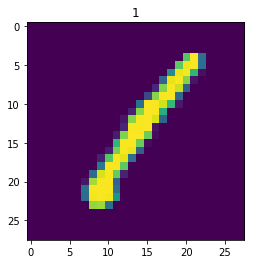

In [11]:
show_digit_image(0, X, y)

(array([3721., 4199., 3774., 3933., 3611., 3423., 3724., 3955., 3681.,
        3779.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

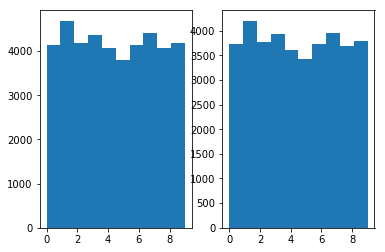

In [12]:
# Is the trainig data balanced?
ax = plt.subplot(1, 2, 1)
ax.hist(y_labels)
ax = plt.subplot(1, 2, 2)
ax.hist(from_categorical(y_train))

First try using the happy house model from the deeplearning.ai course (possibly modified for the iceberg challenge):

In [13]:
def HappyModel(input_shape, num_classes):

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(16, (3, 3), strides=(1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2,2), name='m1')(X)
    
    
    X = Conv2D(16, (3, 3), strides=(1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2,2), name='m2')(X)
    
    # Why flatten?
    X = Flatten()(X)
    
    # Dense layer + softmax - understand why this is good
    X = Dense(10, activation='relu', name='fc1')(X)
    X = Dense(num_classes, activation = 'softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model

happyModel = HappyModel(X_train.shape[1:], 10) #28x28x1
print(X_train.shape[0], ' training samples')
happyModel.summary()

Instructions for updating:
Colocations handled automatically by placer.
37800  training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 16)        160       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 32, 32, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
m1 (MaxPooling2D)            (None, 16, 16, 16)        0         
______________________________________________

In [15]:
# fit the model
# use categorical crossentropy because we have 10 categories
# use accuracy because that is the metric we want to measure on
happyModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
happyModel.fit(x = X_train, y = y_train, epochs = 10, batch_size=16)

Epoch 1/10
37800/37800 [==============================] - 22s 585us/step - loss: 0.0479 - categorical_accuracy: 0.9852
Epoch 2/10
37800/37800 [==============================] - 21s 558us/step - loss: 0.0441 - categorical_accuracy: 0.9857
Epoch 3/10
37800/37800 [==============================] - 21s 549us/step - loss: 0.0366 - categorical_accuracy: 0.9881
Epoch 4/10
37800/37800 [==============================] - 21s 545us/step - loss: 0.0364 - categorical_accuracy: 0.9884
Epoch 5/10
37800/37800 [==============================] - 23s 608us/step - loss: 0.0334 - categorical_accuracy: 0.9896
Epoch 6/10
37800/37800 [==============================] - 21s 558us/step - loss: 0.0282 - categorical_accuracy: 0.9907
Epoch 7/10
37800/37800 [==============================] - 22s 592us/step - loss: 0.0286 - categorical_accuracy: 0.9904
Epoch 8/10
37800/37800 [==============================] - 20s 518us/step - loss: 0.0241 - categorical_accuracy: 0.9927
Epoch 9/10
37800/37800 [========================

In [16]:
# calculate the model predictions
y_predictions = happyModel.predict(X_validation)
model_results = pd.DataFrame({'y_val': from_categorical(y_validation), 'y_pred': from_categorical(y_predictions)})
model_results['is_correct'] = model_results['y_val'] == model_results['y_pred'] 

# print the validation result
happyModel.evaluate(x = X_validation, y = y_validation)

4200/4200 [==============================] - 1s 156us/step


[0.06160443321646502, 0.9816666666666667]

In [39]:
model_results[(~model_results['is_correct']) & (model_results['y_pred'] == 9)]

#show_digit_image(43, X_validation, y_predictions, y_validation)

,y_val,y_pred,is_correct
43,4,9,False
97,7,9,False
664,4,9,False
694,4,9,False
697,8,9,False
911,4,9,False
1162,7,9,False
1408,4,9,False
1943,4,9,False
2382,4,9,False


In [18]:
confusion_matrix(model_results['y_val'], model_results['y_pred'], labels = np.arange(10))
#len(np.where(from_categorical(y_predictions) == 0)[0])


array([[408,   0,   1,   0,   0,   0,   1,   0,   1,   0],
       [  0, 480,   0,   2,   0,   1,   0,   0,   2,   0],
       [  1,   1, 398,   1,   0,   0,   0,   0,   1,   1],
       [  0,   0,   1, 411,   0,   2,   0,   0,   4,   0],
       [  1,   2,   1,   0, 440,   0,   2,   0,   0,  15],
       [  0,   1,   0,   1,   0, 368,   1,   0,   1,   0],
       [  2,   1,   0,   0,   2,   2, 402,   0,   4,   0],
       [  0,   1,   3,   1,   0,   0,   0, 436,   1,   4],
       [  0,   0,   0,   0,   0,   1,   0,   0, 380,   1],
       [  2,   0,   0,   1,   2,   1,   0,   1,   2, 400]], dtype=int64)

In [27]:
#create subission - also save model?
submission_name = 'lene_1'
test_result = predict_on_test(happyModel, X_test)
test_result.to_csv('../submissions/'+submission_name+'.csv', sep = ',', index = False)
happyModel.save('../submissions/'+submission_name+'.h5')
test_result.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [21]:
#is this correct?
np.all(from_categorical(to_categorical(y_labels)) == y_labels)

True